# Synthetic Image Generator for YOLO models

This notebook generates synthetic images for the training, validation and testing. The output of this notebook is required by the **zaxis_train.ipynb** notebook.

Authors(s): *Diptabrata Paul, Martin Fränzl*, edited by *Till Pfaff*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from matplotlib import colormaps as cmaps
import os
from tqdm import tqdm
import yaml
from importlib import reload  # Python 3.4+
import pandas as pd

import image_generator as ig

from yundon_functions import *
pi = np.pi
from multiprocessing import Pool
from PIL import Image
from cv2 import resize
from itertools import repeat
from matplotlib.patches import Rectangle, Circle
# %matplotlib widget
import cv2

def plot_result(ax,img,objects, vmin=1.95e4, vmax=2.05e4):
    if isinstance(img, PIL.Image.Image) or isinstance(img, np.ndarray):
        pass
    elif(type(img) == str):
        img = PIL.Image.open(img)
    ax.imshow(img,cmap="grey",vmin=vmin,vmax=vmax)
    ax.axis("off")
    for i,obj in objects.iterrows():
        l,x,y,w,h = obj[:5]
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
        tx,ty = rect.get_xy()
        ax.add_patch(rect)
        tx+=6
        ty-=12
        circle = Circle((x,y),1, facecolor="red",edgecolor="red")
        ax.add_patch(circle)
        if l == "Ripple":
            ax.text(tx,ty,f"{obj["z"]*0.134:.3f}",fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))

## Display single image for parameter adjustments


Downsampled reference stack shape: (1568, 256, 256)


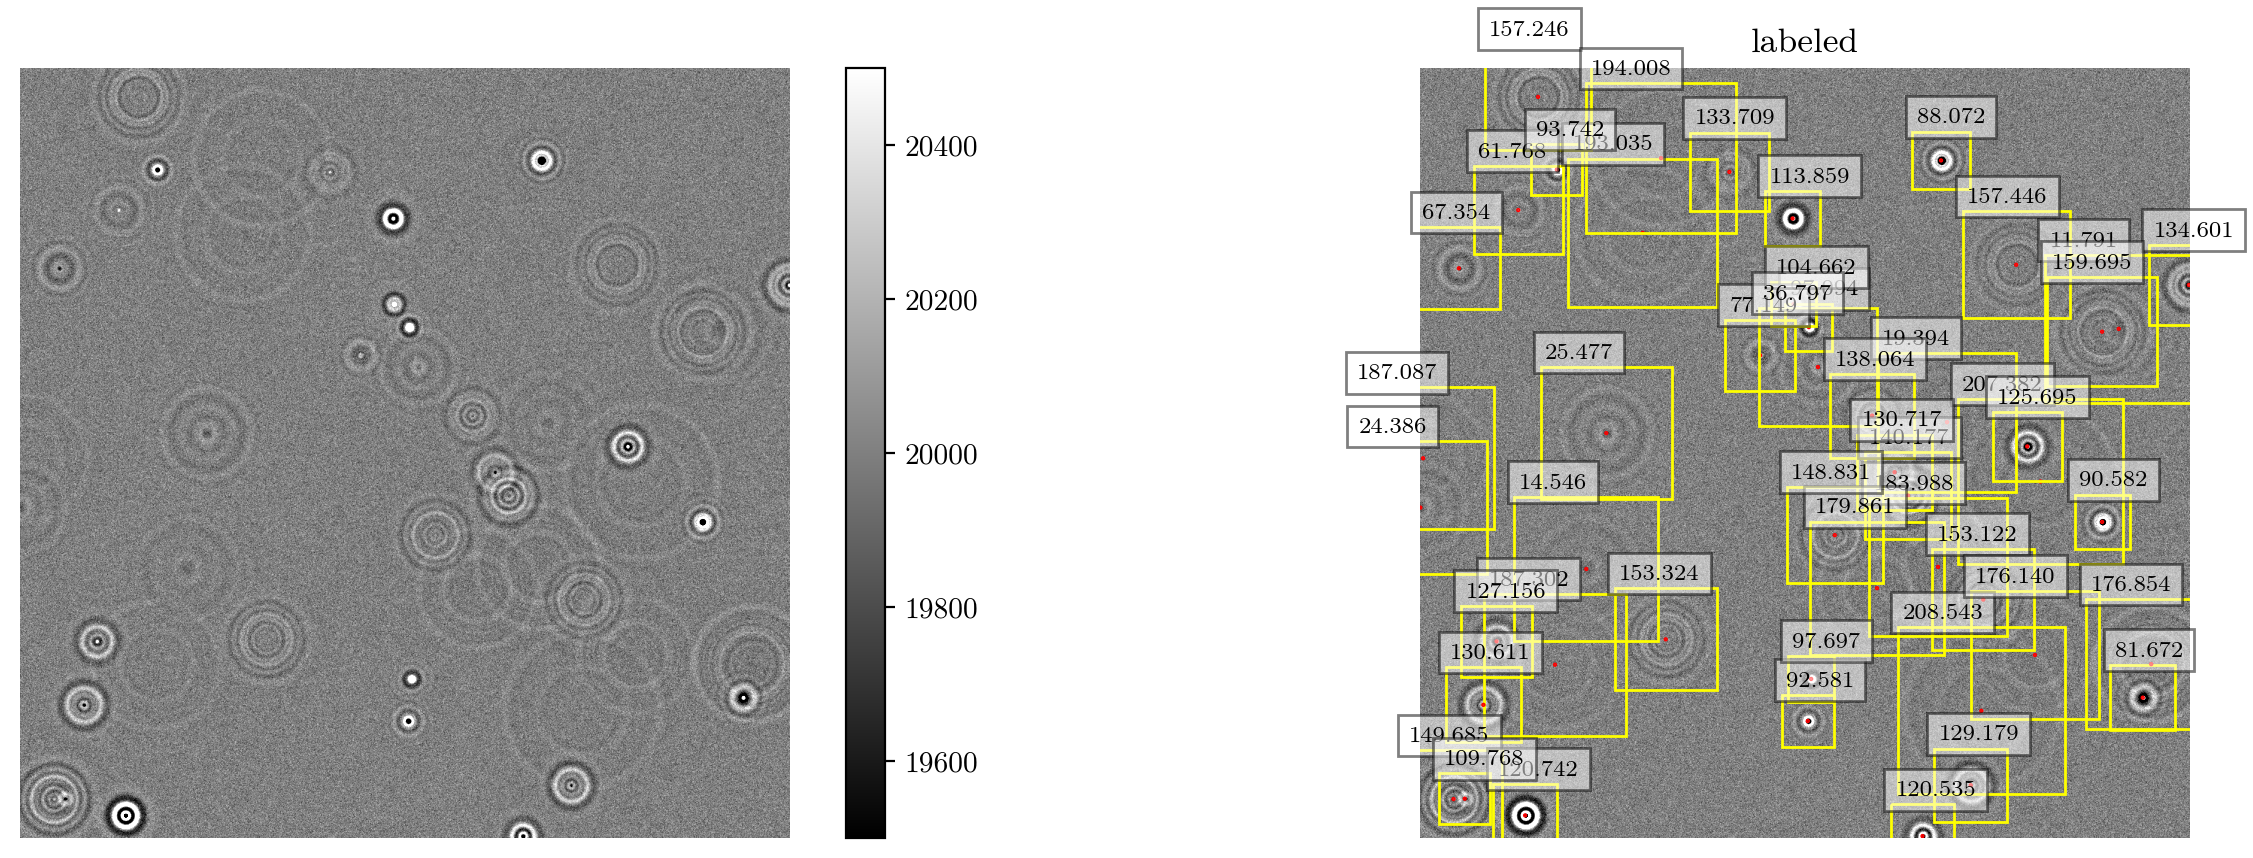

In [2]:
# Configuration for the image generation
reload(ig)
# each object type has a dictionary
ripple_params = {"label":"Ripple",  "z":[0,1567], "i":("gaussian", [0.75,0.25]), "n":(30,90)}
spot_params = {"label":"Spot", "i":("gaussian", [2**15]), "s":8, "n":(30,90)}
janus_params = {"label":"Janus", "i":("gaussian", [2**15,10000]), "s":[2,4],"r":[2,5], "n":(30,90)}
# the object dictionaries are collected in a list
parameter_list = [ripple_params]

# Load the downsampled reference stack
downsampled_refstack = (np.load("refstack256.npy"))-2e4 # shape (1568, 256,256)
print("Downsampled reference stack shape:", downsampled_refstack.shape)
x0, y0 = 64.4*2, 63.7*2 # Center of the reference stack


image_size = 1024,1024       # Dimension 
distance = 0               # Min distance between points
offset = 0                # Boundary padding
noise_range = [100,110]      # Range of noise

objects = ig.getRandom(parameter_list, image_size, distance=distance, offset=offset)

plt.close("all")

plt.figure(figsize=(16,5))
image,_ = ig.generateImage(objects, image_size, refstack=downsampled_refstack, refstack_center=(y0,x0),noise=noise_range, background=2e4)
ax = plt.subplot(1,2,1)
ax.axis("off")
plt.imshow(image, cmap="grey",vmin=1.95e4,vmax=2.05e4)
plt.colorbar()

ax = plt.subplot(1,2,2)
plt.title("labeled")
plot_result(ax,image,objects)
ax.axis("off")

# plt.tight_layout()
plt.show()



For further information, also have a look at the [reference](./ig_docs) for the `image_generator` module.


## Generate images for training, validation and testing

In [3]:
subdir = '../datasets/Dataset_ripples256/'
nimages = [15000,5000,1000]
folders = ["train", "val_slow", "val"]
# test_noiselevels = noise_range*3

# resize_to = 540,640 #subsequent resize to have correct scale
# levels = 20
# nimages = [1000]*levels
# test_noiselevels = list(np.linspace(*snr_range, levels))# use noise range for train and val, and ascending noise levels for test
# folders = [f'test_snr{i}' for i in test_noiselevels]
import time
reload(ig)
if not os.path.exists(subdir):
    os.mkdir(subdir)

l_dir = subdir  + 'labels'
i_dir = subdir + 'images'
if not os.path.exists(i_dir):
    os.mkdir(i_dir)
if not os.path.exists(l_dir):
    os.mkdir(l_dir)
for i, prefix in enumerate(folders):
    image_dir = i_dir + '/' + prefix + '/'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    label_dir = l_dir + '/' + prefix + '/'
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)
for i, prefix in enumerate(folders):


    # print(f"generating {prefix} data... ",end=" ", flush=True)
    vectorized_index = np.vectorize(lambda labels,item: labels.index(item))
    rngs = []
    def init():
        # Initialize the random number generator for each process
        global rng #the rng variable is global so that it can be used in the call function
        rng = np.random.default_rng()
        time.sleep(rng.uniform(0,2))
    def call(j):
        labelname = l_dir + '/' + prefix + '/' + 'image_{:05d}.txt'.format(j,2)    
        fname = i_dir + '/' + prefix + '/' + 'image_{:05d}.tif'.format(j,2)


        objects = ig.getRandom(parameter_list, image_size, rng=rng)

        if(len(objects) == 0):
            f = open(labelname, "w")
            f.write("\n")
            f.close()
            return

        image, info_dict = ig.generateImage(objects, image_size, refstack=downsampled_refstack, refstack_center=(y0,x0), noise=noise_range, rng=rng)
        image = (image).astype(np.uint16) #cast image to 16 bit uint for tiff
        imgshape = image.shape
        # if(resize_to == image_size):
            # image = Image.fromarray(image).save(fname, quality=100)
        # else:
            # image = Image.fromarray(image).resize(resize_to[::-1]).save(fname, quality=100)
        image = Image.fromarray(image).save(fname, quality=100)


        objects[["x","w"]] /= image_size[1] # scale x and w to [0,1]
        objects[["y","h"]] /= image_size[0] # scale y and h to [0,1]
        if "z" in objects.columns: # scale z to µm for type ripples
            objects["z"] = (objects["z"]-761)*0.134 

        # turn label into int:
        objects["label"]=pd.factorize(objects["label"])[0]

        # add keypoint coordinates
        objects[["kpt_x", "kpt_y"]] = objects[["x", "y"]]

        # get labels


        # print(class_id)

        
        np.savetxt(labelname, objects[["label", "x", "y", "w", "h", "z", "kpt_x", "kpt_y"]].values, fmt='%g')# label x y w h z x y
    with Pool(initializer=init) as pool:
        for _ in tqdm(pool.imap_unordered(call,range(nimages[i])),total=nimages[i], desc=prefix):
            pass
    global rng
    rng = np.random.default_rng()
    # for j in tqdm(range(nimages[i]), desc=prefix):

    #     call(j)
        # print(annotations)
    
        
# ig.exportConfig(subdir + 'info.txt', nimages, label_list, parameters_list, n_list, snr_range, i_range, distance, offset)

val: 100%|██████████| 1000/1000 [00:27<00:00, 36.45it/s]


### Generate .yaml file:

In [12]:
file_path = '../datasets/ripples256.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val"
dict["val_slow"]=os.getcwd() + '/' + subdir + "images/" + "val_slow"
dict["kpt_shape"] = [1,2]
dict["num_extra_parameters"] = 1
dict["extra_param_names"] = ["z"]
dict['nc'] = 1
dict['names'] = ["Ripple"]

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)

In [ ]:
subdir = '../datasets/Dataset_spots/'
# folders = ["val_real"]
folders = [f'test_snr{i}' for i in test_noiselevels]


levels_dir = subdir+"/levels"
if not os.path.exists(levels_dir):
    os.mkdir(levels_dir)

for folder in folders:
    file_path = levels_dir + f'/dataset_{folder}.yaml'
    print(file_path)

    dict = {}
    i_dir =  os.getcwd() + '/' + subdir + "images/" + folder
    dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
    dict["val"]=i_dir
    dict["kpt_shape"] = [1,2]
    dict["num_extra_parameters"] = 2
    dict['nc'] = 1
    dict['names'] = ["Spot"]

    with open(file_path, 'w') as file:
        yaml.dump(dict, file, default_flow_style=True)

../datasets/Dataset_spots//levels/dataset_test_snr1.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr2.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr3.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr4.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr5.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr6.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr7.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr8.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr9.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr10.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr11.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr12.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr13.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr14.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr15.0.yaml
../datasets/Dataset_spots//levels/dataset_test_snr16.0.yaml
../datasets/Dataset_spots//levels/dataset_test_sn

## Transform the images by yundon into usable format

In [ ]:
subdir = '../datasets/Dataset_subpixel/'
nimages = [1196]
folders = ["val_real"]
test_noiselevels = noise_range*3
resize_to = 540,640 #subsequent resize to have correct scale
# levels = 10
# nimages = [1000]*levels
# folders = [f'test{i}' for i in range(levels)]
# test_noiselevels = list(np.linspace(*noise_range, levels))# use noise range for train and val, and ascending noise levels for test
import time
reload(ig)
if not os.path.exists(subdir):
    os.mkdir(subdir)

l_dir = subdir  + 'labels'
i_dir = subdir + 'images'
if not os.path.exists(i_dir):
    os.mkdir(i_dir)
if not os.path.exists(l_dir):
    os.mkdir(l_dir)
for i, prefix in enumerate(folders):
    image_dir = i_dir + '/' + prefix + '/'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    label_dir = l_dir + '/' + prefix + '/'
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)
for i, prefix in enumerate(folders):


    # print(f"generating {prefix} data... ",end=" ", flush=True)
    vectorized_index = np.vectorize(lambda labels,item: labels.index(item))
    rngs = []
    def init():
        global rng
        rng = np.random.default_rng()
        time.sleep(rng.uniform(0,2))
    def call(j):
        labelname = l_dir + '/' + prefix + '/' + 'image_{:05d}.txt'.format(j,2)    
        fname = i_dir + '/' + prefix + '/' + 'image_{:05d}.tif'.format(j,2)

        x,y,z = gt_yundon(j)
        bx,by,bw,bh = get_bbox(x.copy(),y.copy(),z.copy())
        x*=640
        y*=540
        # print(j)
        image = np.array(open_yundon_img(j).copy())
        if(j==1):
            print((z-0.5)*400)

        # x+=0.5 #account for downsampling artifact
        # y-=0.25
        # plt.imsave(fname, image, cmap='gray',vmin=0,vmax=1)
        image = (image).astype(np.uint16) #cast image to 16 bit tiff
        imgshape = image.shape
        image = Image.fromarray(image).resize(resize_to[::-1]).save(fname, quality=100)

        x /= resize_to[1]
        y /= resize_to[0]
        bw /= resize_to[1]*2
        # by /= resize_to[0]
        # bw=bh = (np.abs((z-0.5)*400)/0.161*0.21+55)
        # bboxes = np.array([x* resize_to[1],y* resize_to[0],bx,by]).T
        # z = (z-761)*0.134/400+0.5

        class_id = np.zeros_like(x)
        i = np.ones_like(x)
        # print(class_id)
        # print(class_id.shape,z.shape, x.shape, y.shape)
        # print([x.shape for x in [class_id,bbox_x.clip(0,1),bbox_y.clip(0,1),bbox_w.clip(0,1),bbox_h.clip(0,1),z.clip(0,1), x.clip(0,1), y.clip(0,1)]])
        np.savetxt(labelname, np.column_stack([class_id,bx.clip(0,1),by.clip(0,1),bw.clip(0,1),bh.clip(0,1),z,i, x.clip(0,1), y.clip(0,1)]), fmt='%g')
    with Pool(initializer=init,processes=1) as pool:
        for _ in tqdm(pool.imap_unordered(call,range(nimages[i])),total=nimages[i], desc=prefix):
            pass
        # print(annotations)
    
        
# ig.exportConfig(subdir + 'info.txt', nimages, label_list, parameters_list, n_list, snr_range, i_range, distance, offset)

val_real:   0%|          | 1/1196 [00:01<28:51,  1.45s/it]

[-15801.13156345    579.7602456  -16366.88604292    489.42727413
 -13953.8397447   -4430.50825574 -31279.1505995   -4637.6961755
  -7527.44992173  -6320.78606597    439.84683771  -6876.80315117
 -16644.76375831 -16929.63819839 -18771.71273453 -19449.2355251
 -21348.07370153 -20591.54211378 -20426.03178545 -18699.15523257
 -26901.10239187  -4374.80575631 -28712.20969367 -29812.38506752
 -41121.84826451 -42703.26483254 -40598.01261732 -38970.48272867
 -40396.09169238]


val_real: 100%|██████████| 1196/1196 [00:13<00:00, 88.81it/s] 


## some patches and tests:

In [ ]:
# import PIL
# from matplotlib.patches import Rectangle
# def plot_gt(path,ax):
#     data=np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt")).T
#     # print(data)
#     print(data.shape)
#     cls = data[0]
#     bboxes = data[1:5].T
#     z = data[5]
#     x_p,y_p = data[6:]
#     # print(bboxes)
#     img = PIL.Image.open(path)
#     img = ax.imshow(np.array(img),cmap="grey", vmin=1.9e4, vmax=2.1e4)
#     ax.axis("off")
#     for bbox,z_value in zip(bboxes,z):
#         x,y,w,h = bbox*512
#         rect = Rectangle((x-0.25*w,y-0.25*h),h,w, linewidth=1, edgecolor="blue", facecolor='none')
#         ax.text(*rect.get_xy(),f"z={z_value:.3f}")
#         ax.add_patch(rect)
#     return bboxes,z, img

(8, 5)


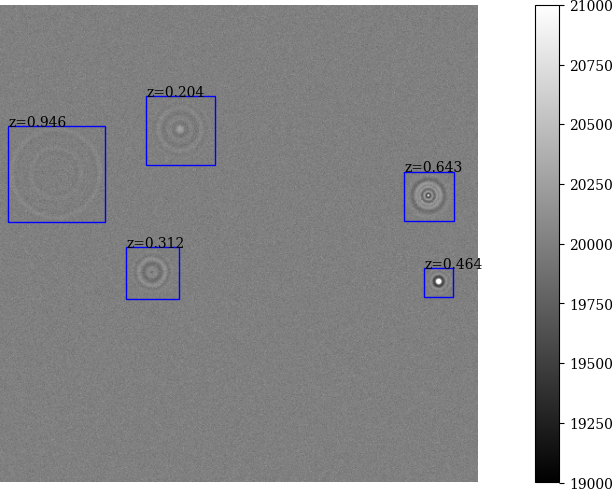

In [ ]:
# plt.clf()
# _,_,img = plot_gt("Dataset/images/test0/image_00006.tif",plt.gca())
# plt.colorbar(img)
# plt.show()

In [ ]:
# np.r_[:8]
# def random_image():
#     idx = np.random.randint(0,len(test_images))
#     path = dataset_path+"/"+test_images[idx]
#     del test_images[idx]
#     return path
# dataset_path = "datasets/Dataset_yundon/images/val_real"
# # dataset_path = "../ultralytics/data_gen/Dataset_hard/images/val"
# test_images = os.listdir(dataset_path)
# import os

In [ ]:
# for i in range(173):
#     img_origin = random_image()
#     label_origin = img_origin.replace("images","labels").replace(".tif", ".txt")

#     img_dest = img_origin.replace("val", "test")
#     label_dest = label_origin.replace("val", "test")

#     os.replace(img_origin, img_dest)
#     os.replace(label_origin, label_dest)

In [ ]:
# import PIL.Image

# test_path = dataset_path.replace("val", "test")
# for img in os.listdir(test_path):
#     imgpath = test_path+"/"+img
#     label_path = imgpath.replace(".tif", ".txt").replace("images", "labels")
#     image = PIL.Image.open(imgpath)
#     image = image.rotate(180)
#     # print(np.array(image).shape)
#     image.save(imgpath)
#     image.close()
#     labels = np.loadtxt(label_path).T
#     labels[[1,2,6,7]] = 1-labels[[1,2,6,7]]
#     np.savetxt(label_path, labels.T)

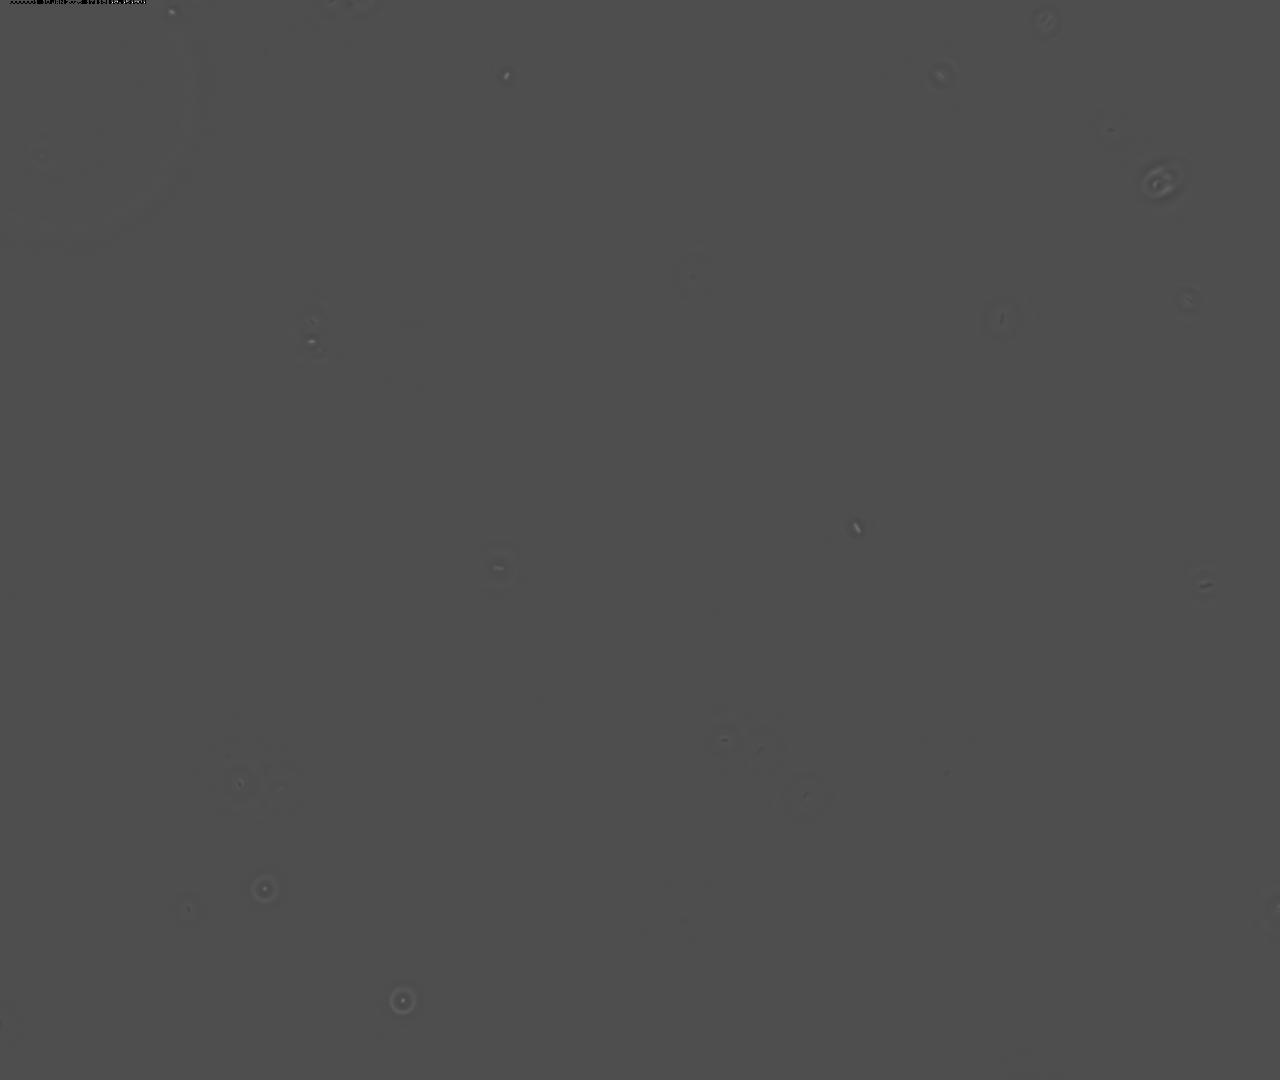

In [11]:
open_yundon_img(34)